In [12]:
# libraries

import pandas as pd
import numpy as np
import load_data
import matplotlib.pyplot as plt

df = load_data.load_train_data()

In [4]:
no_target_df = df.drop('Target', axis=1)

In [7]:
corrs = abs(no_target_df.corrwith(df.loc[:,'Target'], method='spearman')).sort_values(ascending=False)

/var/folders/jp/y175t8cj1xn0v8nx88w4ftv00000gn/T/ipykernel_18179/3438815316.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrs = abs(no_target_df.corrwith(df.loc[:,'Target'], method='spearman')).sort_values(ascending=False)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [9]:
corrs.head(10)

meaneduc         0.375767
SQBmeaned        0.375767
v2a1             0.355873
SQBdependency    0.340087
cielorazo        0.313470
escolari         0.311481
SQBescolari      0.311481
SQBhogar_nin     0.304257
hogar_nin        0.304257
eviv3            0.300456
dtype: float64

In [163]:
df['Target'].value_counts()

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

In [126]:
df['v2a1_log'] = np.log1p(df['v2a1'].fillna(np.mean(df['v2a1'])))

In [144]:
def plot_continuous(df, continuous_col, target_col, cutoff=None):
    """
    Plot target distribution by continuous variable
    
    Parameters:
    df (pandas.DataFrame): Dataframe containing both continuous and target variables
    continuous_col (str): Name of the continuous variable column
    target_col (str): Name of the target variable column
    cutoff (float): Optional cutoff value for the continuous variable
    
    Returns:
    None
    """
    df[continuous_col] = df[continuous_col].fillna(df[continuous_col].mean())
    
    # Cap continuous column at cutoff if specified
    if cutoff:
        df.loc[df[continuous_col] > cutoff, continuous_col] = cutoff
    
    # Define the bins using the distribution of the continuous variable
    if cutoff:
        bins = [df[continuous_col].min(), df[continuous_col].quantile(0.25), df[continuous_col].median(), df[continuous_col].quantile(0.75), cutoff]
    else:
        bins = np.percentile(df[continuous_col], [0, 25, 50, 75, 100])
    bins = np.unique(bins)
    # Create a label for each bin, handling duplicates if necessary
    labels = []
    for i in range(len(bins)-1):
        label = f'{int(bins[i])}-{int(bins[i+1])}'
        count = labels.count(label)
        if count > 0:
            label = f'{label} ({count})'
        labels.append(label)
    
    df[f'{continuous_col}_bin'] = pd.cut(df[continuous_col], bins=bins, labels=labels, include_lowest=True, right=True, duplicates='drop')
    
    # Count target variable by continuous variable bin
    target_by_bin = df.groupby(f'{continuous_col}_bin')[target_col].value_counts(normalize=True).unstack().fillna(0)
    
    # Define the x-axis tick labels
    tick_labels = labels
    
    # Plot the bars
    fig, ax = plt.subplots()
    bar_width = 0.2
    opacity = 0.8
    
    for i in range(len(target_by_bin.columns)):
        rects = ax.bar(np.arange(len(tick_labels))+i*bar_width, target_by_bin.iloc[:,i], bar_width, alpha=opacity, label=f'Target = {target_by_bin.columns[i]}')
    
    # Add axis labels, title, and legend
    ax.set_xlabel(continuous_col)
    ax.set_ylabel('Percentage')
    ax.set_title(f'Target Distribution by {continuous_col}')
    ax.set_xticks(np.arange(len(tick_labels))+0.5*(len(target_by_bin.columns)-1)*bar_width)
    ax.set_xticklabels(tick_labels)
    ax.legend()
    
    plt.tight_layout()
    plt.show()


[ 0.   6.   9.  11.5 21. ]


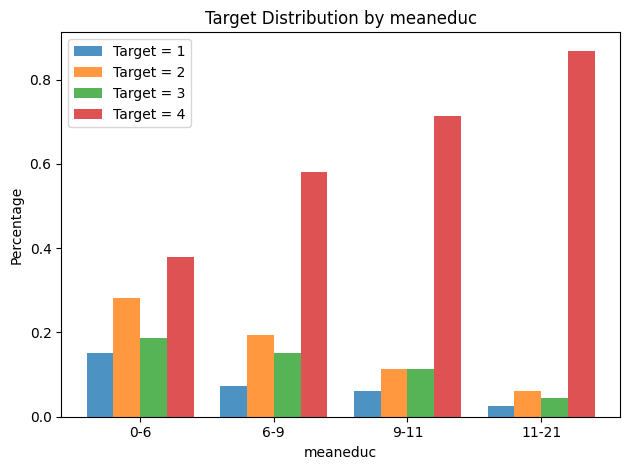

In [140]:
plot_continuous(df, 'meaneduc', 'Target', cutoff=21)

[  0.    36.    81.   132.25 441.  ]


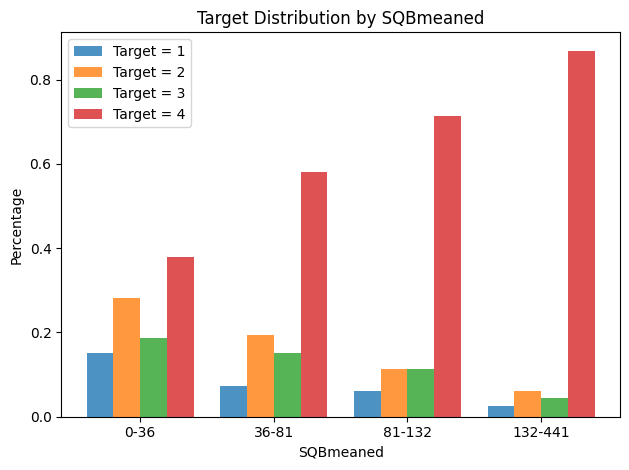

In [141]:
plot_continuous(df, 'SQBmeaned', 'Target', cutoff=441)

[ 0.         12.0151095  14.67140479]


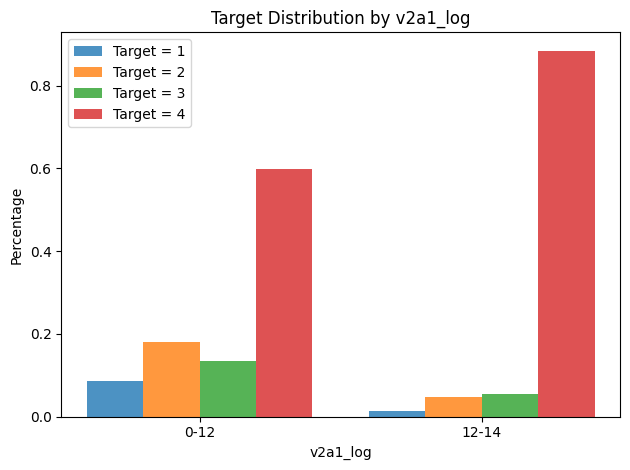

In [139]:
plot_continuous(df,'v2a1_log','Target')

[ 0.          0.11111112  0.44444448  1.7777779  64.        ]


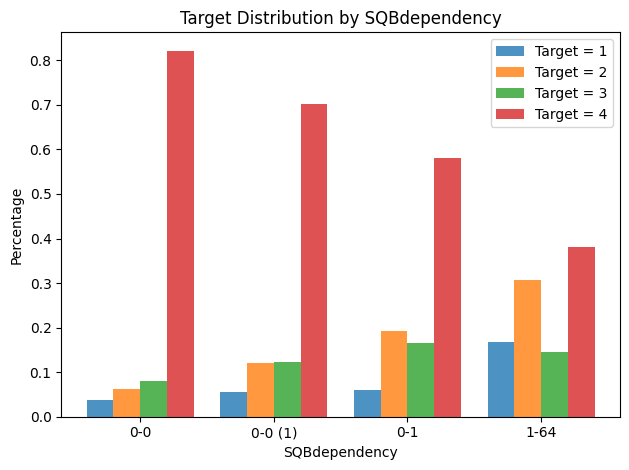

In [143]:
plot_continuous(df,'SQBdependency','Target')

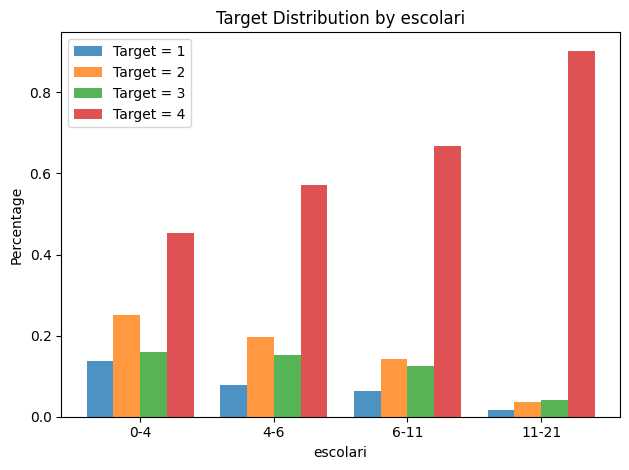

In [147]:
plot_continuous(df,'escolari','Target')

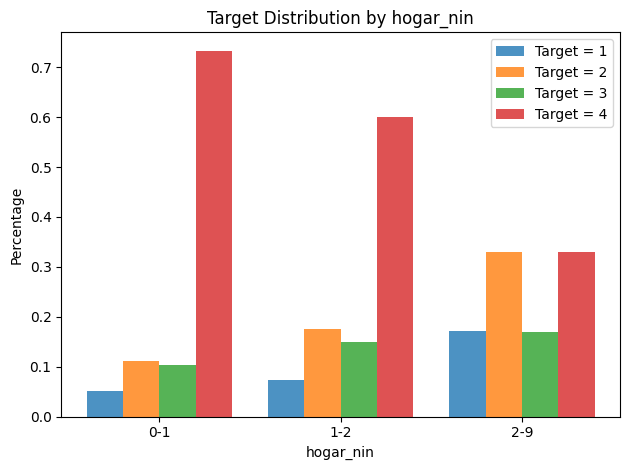

In [148]:
plot_continuous(df,'hogar_nin','Target')

In [157]:
def plot_grouped_bar_chart(df, binary_col, target_col):
    """
    Plots a grouped bar chart showing the percentage of each target category for each value of a binary column.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    binary_col (str): The name of the binary column.
    target_col (str): The name of the target column.

    Returns:
    None
    """

    # Create a grouped bar chart
    fig, ax = plt.subplots()
    bar_width = 0.35
    opacity = 0.8

    # Get the unique values of the binary column
    index = df[binary_col].unique()

    # Count target variable by binary group
    binary_yes = df[df[binary_col] == 1][target_col].value_counts().sort_index().tolist()
    binary_no = df[df[binary_col] == 0][target_col].value_counts().sort_index().tolist()

    # Calculate percentage of total for each target category within each binary group
    binary_yes_perc = [count/sum(binary_yes) * 100 for count in binary_yes]
    binary_no_perc = [count/sum(binary_no) * 100 for count in binary_no]
    binary_yes_target_perc = [binary_yes[i]/(binary_yes[i]+binary_no[i]) * 100 for i in range(len(binary_yes))]
    binary_no_target_perc = [binary_no[i]/(binary_yes[i]+binary_no[i]) * 100 for i in range(len(binary_no))]

    # Define the x-axis tick labels
    tick_labels = sorted(df[target_col].unique())

    # Plot the bars
    rects1 = ax.bar([i - bar_width/2 for i in range(len(tick_labels))], binary_yes_target_perc, bar_width, alpha=opacity, color='b', label=f'{binary_col}=Yes')
    rects2 = ax.bar([i + bar_width/2 for i in range(len(tick_labels))], binary_no_target_perc, bar_width, alpha=opacity, color='orange', label=f'{binary_col}=No')

    # Add axis labels, title, and legend
    ax.set_xlabel(target_col)
    ax.set_ylabel('Percentage of Total')
    ax.set_title(f'{target_col} count by {binary_col}')
    ax.set_xticks([i for i in range(len(tick_labels))])
    ax.set_xticklabels(tick_labels)
    ax.legend()

    plt.tight_layout()
    plt.show()

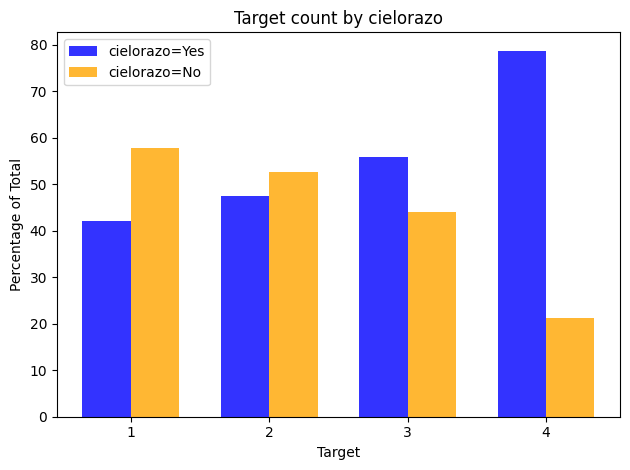

In [158]:
plot_grouped_bar_chart(df, 'cielorazo', 'Target')

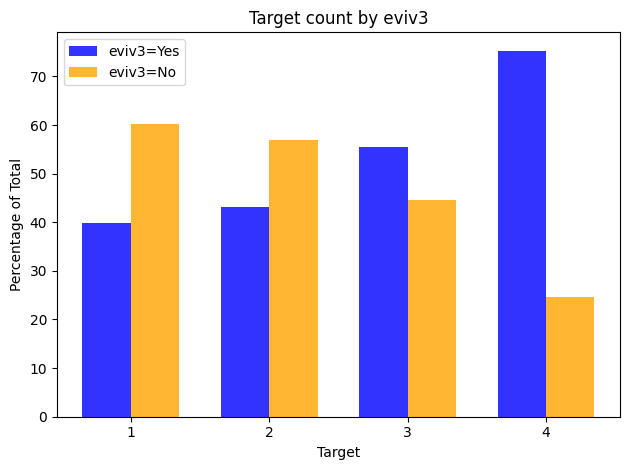

In [159]:
plot_grouped_bar_chart(df, 'eviv3', 'Target')

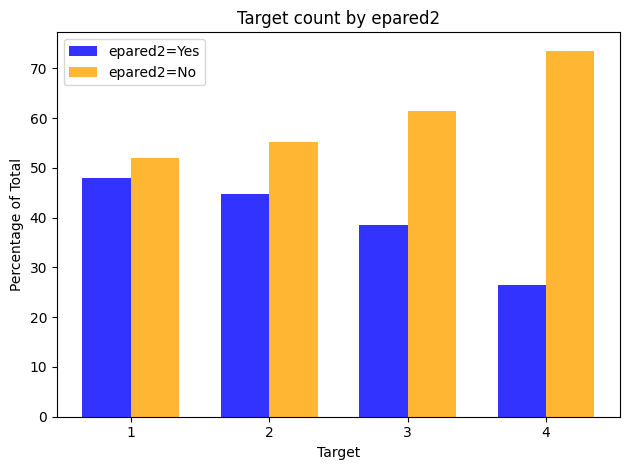

In [162]:
plot_grouped_bar_chart(df,'epared2','Target')

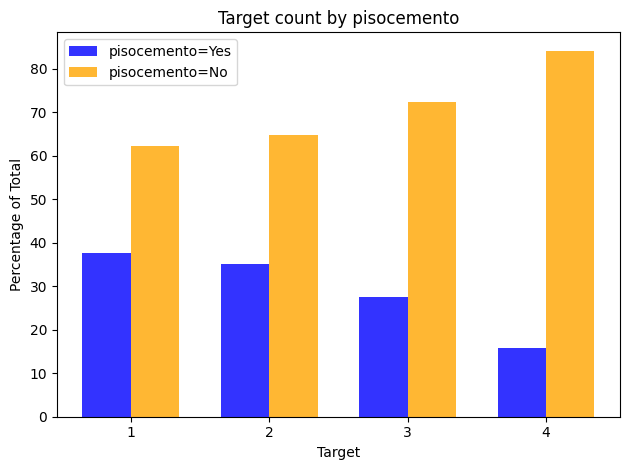

In [164]:
plot_grouped_bar_chart(df,'pisocemento','Target')